## New TAS Map
<pre> 
Reutilizando código de Borja Leirado
Modificado para crear ecsv más completo, 
similar al usado para NixNox clásico
2022/07/11
2024/01/17   avoid location in arab characters
2024/07/29   lee fechas en formato diferente
</pre>

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from astropy.table import Table, vstack
from astropy.time import Time
from astropy.coordinates import Angle
import astropy.units as u
import os
from glob import glob
from pathlib import Path
import datetime
from collections import OrderedDict
import unicodedata

from datetime import datetime   
import pytz

from tzwhere import tzwhere

In [2]:
# Para encontrar la localidad
from geopy.geocoders import Nominatim
# Initialize Nominatim API
#geolocator = Nominatim(user_agent="geoapiExercises")
geolocator = Nominatim(user_agent='cefalopodo@gmail.com')
#from geopy.extra.rate_limiter import RateLimiter
#geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [3]:
Latitude  = "40.725677" 
Longitude = "-4.860739"
sitio = geolocator.geocode(Latitude+","+Longitude,timeout=None)
print(sitio)

Calle de la Iglesia, Bularros, Ávila, Castilla y León, España


In [4]:
# Problemas con sitio en dos idiomas
Latitude   = "34.993218" 
Longitude = "-4.841983"
sitio = geolocator.geocode(Latitude+","+Longitude,timeout=None)
print(sitio)
Latitude   = "34.993218" 
Longitude = "-4.841983"
#sitio = geolocator.geocode(Latitude+","+Longitude,addressdetails=True,timeout=None)
#print(sitio)
#print(sitio.raw)
sitio = geolocator.reverse(Latitude+","+Longitude,timeout=None)
print(sitio)

RN2, Iounane إيونان, Caïdat de Bab Berred, Cercle de Bab Berred, Province de Chefchaouen ⵜⵛⴻⴼⵜⵛⴰⵡⴻⵏ إقليم شفشاون, Tanger-Tétouan-Al Hoceïma ⵟⴰⵏⵊ-ⵟⵉⵜⴰⵡⵉⵏ-ⵍⵃⵓⵙⵉⵎⴰ طنجة تطوان الحسيمة, Maroc ⵍⵎⵖⵔⵉⴱ المغرب
RN2, Iounane إيونان, Caïdat de Bab Berred, Cercle de Bab Berred, Province de Chefchaouen ⵜⵛⴻⴼⵜⵛⴰⵡⴻⵏ إقليم شفشاون, Tanger-Tétouan-Al Hoceïma ⵟⴰⵏⵊ-ⵟⵉⵜⴰⵡⵉⵏ-ⵍⵃⵓⵙⵉⵎⴰ طنجة تطوان الحسيمة, Maroc ⵍⵎⵖⵔⵉⴱ المغرب


In [5]:
# Tratando de filtrar caracteres árabes
print(sitio[1])
print(sitio[0])
new_location = ""
for i in range(len(sitio[0])):
        #print(sitio[0][i],ord(sitio[0][i]))
        if ord(sitio[0][i]) < 1500:
            new_location = new_location + sitio[0][i]
print(new_location)
location = new_location.replace("  ,",",")
location = location.replace(" ,",",")
print(location)

(34.99468241630253, -4.8422738152410165)
RN2, Iounane إيونان, Caïdat de Bab Berred, Cercle de Bab Berred, Province de Chefchaouen ⵜⵛⴻⴼⵜⵛⴰⵡⴻⵏ إقليم شفشاون, Tanger-Tétouan-Al Hoceïma ⵟⴰⵏⵊ-ⵟⵉⵜⴰⵡⵉⵏ-ⵍⵃⵓⵙⵉⵎⴰ طنجة تطوان الحسيمة, Maroc ⵍⵎⵖⵔⵉⴱ المغرب
RN2, Iounane , Caïdat de Bab Berred, Cercle de Bab Berred, Province de Chefchaouen   , Tanger-Tétouan-Al Hoceïma --   , Maroc  
RN2, Iounane, Caïdat de Bab Berred, Cercle de Bab Berred, Province de Chefchaouen, Tanger-Tétouan-Al Hoceïma --, Maroc  


In [6]:
# Para encontrar timezone
from tzwhere import tzwhere

tzwhere = tzwhere.tzwhere()
timezone_str = tzwhere.tzNameAt(33.242383, -114.178) # 
#timezone_str = tzwhere.tzNameAt(40.830408, -2.801691)
timezone_str
print(timezone_str)

# Para encontrar UTC
local = pytz.timezone(timezone_str)

naive = datetime.strptime("2001-2-3 10:11:12", "%Y-%m-%d %H:%M:%S")
print('LT',naive)
local_dt = local.localize(naive, is_dst=None)
utc_dt = local_dt.astimezone(pytz.utc)
UTC = utc_dt.strftime("%Y-%m-%d %H:%M:%S")
print('UTC',UTC)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


America/Phoenix
LT 2001-02-03 10:11:12
UTC 2001-02-03 17:11:12


In [7]:
def LT2UT(date_str,latitude,longitude):
    '''convers local time to UT time'''
    #tzwhere = tzwhere.tzwhere()
    #print(date_str,latitude,longitude)
    timezone_str = tzwhere.tzNameAt(latitude, longitude)
    #### print(timezone_str)
    local = pytz.timezone(timezone_str)
    naive = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    local_dt = local.localize(naive, is_dst=None)
    utc_dt = local_dt.astimezone(pytz.utc)
    #### print(naive,local_dt,utc_dt)
    UTC = utc_dt.strftime("%Y-%m-%d %H:%M:%S")
    return UTC

In [8]:
UTC = LT2UT("2001-2-3 10:11:12",33.242383, -114.178)
UTC = LT2UT("2022-7-13 22:11:12",40.830408, -2.801691)
UTC = LT2UT("2022-10-26 20:38:00",64.4296048, -173.2195792)
UTC = LT2UT('2022-11-13 21:08:54',40.64187,-3.090833)
print(UTC)

2022-11-13 20:08:54


In [9]:
LT2UT('2022-10-26 20:38:00',64.4296048, -173.2195792)
LT2UT('2022-11-13 21:08:54',40.64187,-3.090833)

'2022-11-13 20:08:54'

In [10]:
plt.style.use('mimaps')

In [11]:
#directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TAS4C6-JoseAntonioRodriguez
#directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASB0A-GOAA/'
#directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TAS4C6-JoseAntonioRodriguez/'
# directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASFCB-Bullon/'
#directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASF46-FernandoGarcia/'
#directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TAS6C6-JesusCarmona/'
#directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASB46-Zamorano/'
#directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD00-SAG-AngelVilchez/'

#directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASC8F-GeorgiaMacMillan/'

directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TAS50D-StefanoKlett/'
directory = '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/'


print(directory)

/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/


In [12]:
#globpath = os.path.join(directory, 'NOX*Ermita*.txt')
#globpath = os.path.join(directory, '*022615_Kofa.txt')
#globpath = os.path.join(directory, '*NOX*.txt')
#globpath = os.path.join(directory, '*_AS_*.txt')
globpath = os.path.join(directory, '*2024*txt')
#globpath = os.path.join(directory, 'TAS*txt')
print(globpath)
# glob searches through directories similar to the Unix shell
filelist = sorted(glob(globpath))
print(filelist)    # printing only from 10 to 20

/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/*2024*txt
['/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/TASD4B_AS_2024-10-23_223741_CASLEO.txt', '/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/TASD4B_AS_2024-10-23_224926_CASLEO.txt']


In [13]:
class PhotometerObs():

    """Main photometer class. Reads from .ecsv and performs map generations and diverse operations."""

    def __init__(self, ecsv_path, name = 'Observation', surname = ''):
        """Instance initializes by reading the ecsv file in ecsv_path."""

        pos0  = ecsv_path.rfind('/')
        self.file_txt = ecsv_path[pos0+1:].replace('ecsv','txt')
        pos1  = ecsv_path.rfind('_')
        self.file_txt_reduced = ecsv_path[pos0+1:pos1]
        self.name = name
        self.surname = surname
        self.ecsv_path = ecsv_path
        # Reads .ecsv data
        self.data = Table.read(self.ecsv_path, format='ascii.ecsv', delimiter=',')
        self.magnitudes = self.data['Mag']  # All magnitude values
        self.temperatures = self.data['Temp_IR']  # All sky temperatures
        self.azimuths = self.data['Azi']  # All azimuth values
        self.zeniths = 90 - self.data['Alt']  # All zeniths values
        ####### self.magnitud_zenith = np.mean(self.data[self.data['Azi'] == 90]['Mag'])
        self.magnitud_zenith = np.mean(self.data[self.data['Alt'] == 90]['Mag'])

        '''Latitudes and longitudes'''

        self.mean_LAT = Angle(np.mean(self.data['Lat']), unit=u.deg)  # degrees
        self.mean_LONG = Angle(np.mean(self.data['Long']), unit=u.deg)  # degrees

        '''Date'''
        num_medidas = len(self.data['Datetime'])
        medio = int(num_medidas / 2)
        self.LT_mean_datetime = self.data['Datetime'][medio]
        self.UT_mean_datetime = LT2UT(self.LT_mean_datetime,self.mean_LAT.value,self.mean_LONG.value)
        
        self.LT_time_ini =  self.data['Datetime'][0]
        print('mean_datetime (LT)',self.LT_mean_datetime)
        self.data.meta['LT_mean_date'] = self.LT_mean_datetime
        self.data.meta['UT_mean_date'] = self.UT_mean_datetime
        self.data.meta['mean_LONG'] = self.mean_LONG
        self.data.meta['mean_LAT'] = self.mean_LAT
        self.data.meta['measurements_file'] = self.file_txt 
### Once ecsv is read ###
    def __interpolate_measurements__(self):

        '''
        Interpolate to create grid. Needed to be performed before magnitud_map() 
        if interpolated == True.

         * squaresize -- int: Lenght of the side of the square for the interpolation grid
         * method -- str: {'linear', 'nearest', 'cubic'} Method of interpolation

        '''
        step = 1
        zen = np.arange(0, np.max(90 - self.data['Alt']) +1, step)  # grid values in zen direction
        azi = np.arange(0, 361, step)  # grid values in azi direction

        # '''Create periodic boundary conditions for interpolation'''

        data = self.data
        dfa = data.copy()
        dfa['Azi'] = dfa['Azi'] + 360

        dfb = data.copy()
        dfb['Azi'] = dfb['Azi'] - 360
        self.periodic_data = vstack([data, dfa, dfb])

        self.periodic_magnitudes   = np.array(self.periodic_data['Mag'])
        self.periodic_temperatures = np.array(self.periodic_data['Temp_IR'])        
        self.periodic_zeniths      = 90 - np.array(self.periodic_data['Alt'])
        self.periodic_azimuths     = np.array(self.periodic_data['Azi'])

        ZEN, AZI = np.meshgrid(zen, azi)  # coordinated zen and azi (for vectorized computations) INTERPOLATION grid
        r, theta = np.meshgrid(zen, np.radians(azi))  # coordinated zen and azi (for vectorized computations)
# magnitudes
        VALUES_m = griddata((self.periodic_zeniths, self.periodic_azimuths), self.periodic_magnitudes, (ZEN, AZI),
                          method = 'cubic')  # Interpolated values (magnitudes) for the grid points

        values   = np.array(VALUES_m)  # INTERPOLATED magnitudes but array instead of meshgrid
        values_m = values.reshape(len(azi), len(zen))
# temperatures
        VALUES_t = griddata((self.periodic_zeniths, self.periodic_azimuths), self.periodic_temperatures, (ZEN, AZI),
                          method = 'cubic')  # Interpolated values (temperatures) for the grid points
        values   = np.array(VALUES_t)  # INTERPOLATED temperatures but array instead of meshgrid
        values_t = values.reshape(len(azi), len(zen))

        self.i_azimuths     = theta
        self.i_zeniths      = r
        self.i_magnitudes   = values_m
        self.i_temperatures = values_t
        
        gradient = np.gradient(VALUES_m)
        gradient[0] = -gradient[0]  #change sign to be consistent with azimuth definition


        i_data = {
            'azimuth': theta.ravel(),
            'zenith': r.ravel(),
            'magnitude': values_m.ravel(),
            'temperature': values_t.ravel(),
            'gradient_azi': gradient[0].ravel(),
            'gradient_zen': gradient[1].ravel()
        }

        self.unraveled_data = {
            'azimuth': theta,
            'zenith': r,
            'magnitude': values_m,
            'temperature': values_t,
            'gradient_azi': gradient[0],
            'gradient_zen': gradient[1]
        }

        self.i_data_table = Table(i_data)
        self.i_data_table.meta = self.data.meta
        self.initial_azi = azi
        self.initial_zen = zen
        

In [14]:
lati = Angle('54:59:21.413', unit=u.deg)
longi = Angle('-10:34:22.457', unit=u.deg)
print(lati.value,longi.value)

54.98928138888889 -10.572904722222223


In [15]:
class TASObs(PhotometerObs):

    def __init__(self, txt_path, meta_dict, name='Observation', ecsv_path=None, surname=''):
        """Reads a forms .txt file and transforms it into a .ecsv file standarized for nixnox."""

        # Transforms .txt to astropy table

        table = Table(
            data=None,
            names=['ind', 'Datetime', 'UT_Datetime', 'Temp_IR', 'T_sens', 'Mag', 'Hz', 'Alt', 'Azi', 'Lat', 'Long', 'SL'],
            dtype=['int64', 'str', 'str', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'float64',
                   'float64', 'int64']
        )

        metadata = {'measurements_file' : None ,'location' : None , 'place' : "",
                'latitude' : None ,'longitude' : None , 'height' : 0,
                'author' : None, 'association' : None, 'photometer' : None,
                'LT_mean_date' : None ,'LT_time_ini' : None , 'LT_time_end' : None,
                'timezone' : None,
                'UT_mean_date' : None ,'UT_time_ini' : None , 'UT_time_end' : None}  
        
        with open(txt_path, 'r', encoding='utf-8', errors='ignore') as file_object:  # Abrir el fichero

            metadata['measurements_file'] = txt_path[txt_path.rfind('/')+1:]
            
            lines = file_object.readlines()
            comments = ''
            for line in lines:  # Corregir las lineas
                if line.startswith('#'):  # Omitir los comentarios
                    comments = comments + line.strip() +' '
                    pass
                else:
                    line = line.rstrip()  # Quitar espacio final
                    line = re.sub(r',', '.', line)  # Cambiar comas a puntos
                    line = re.sub(r'\s+', ';', line)  # Cambiar separación a ;
                    line = line.split(';')
                    #####print(line)
                    if len(line)>12:       # new versions include battery level as 11th column
                        line = line[:-1]
                    # Azi altitude to float (degrees)
                    ## print('azi,alt',line[7],line[8])
                    line[7] = Angle(line[7], unit=u.deg)
                    line[8] = Angle(line[8], unit=u.deg)
                    #print(line[8])
                    if 'NOX' in txt_path:  # Juampa files rotated 180 deg
                        line[8] = line[8] + 180*u.deg
                        if line[8] > 360*u.deg :
                            line[8] = line[8] - 360*u.deg
                    #print(line[8])
                    # Lat longitude to float (degrees)
                    if str(line[9]) != '0':    # LAT,LONG values in this line
                        lati = Angle(line[9], unit=u.deg)
                        line[9] = lati
                        longi = Angle(line[10], unit=u.deg)
                        line[10] = longi
                    else:
                        line[9] = lati       # no LAT,LONG values, takes the first 
                        line[10] = longi
        
                    ####print('lat,long',line[9],line[10],lati,longi)
                    # Datetime column
                    if ':' in line[1]:     # formato raro de fecha y hora  2024:7:2 1:34:16
                        #ndate = line[1].split(':')
                        #y = ndate[0]
                        #m = ndate[1]
                        #if len(str(m)) < 2: *********************
                            
                        #d = ndate[2]
                        #ntime = line[2].split(':')
                        #h = ntime[0]
                        #m = ntime[1]
                        #s = ntime[2]
                        #line[1] = str(y)+'-'+str(m)+'-'+str(d)
                        line[1] = line[1].replace(':','-')
                    line[1] = line[1] + ' ' + line[2]  # date + time
                    ##line.pop(2)                        # remove time column
                    line[2] = LT2UT(line[1],line[9].value, line[10].value)
                    #print(table.info)
                    table.add_row(line)
                    
        metadata['comments'] = comments.replace('\t',' ')
        num_medidas = len(table)
        medio = int(num_medidas / 2)
        LT_mean_datetime = str(table['Datetime'][medio])
        metadata['LT_mean_date'] = LT_mean_datetime
        metadata['LT_time_ini'] = str(table['Datetime'][0])
        metadata['LT_time_end'] = str(table['Datetime'][-1])
        pos0  = txt_path.rfind('/')
        pos1  = txt_path.rfind('_')
        photometer = txt_path[pos0+1:pos0+7]
        metadata['photometer'] = photometer
        place = str(txt_path[pos1+1:])[:-4].replace('-',' ')
        metadata['place'] = place
        
        latitude      = table['Lat'][0]
        latitude_str  = str(latitude)
        longitude     = table['Long'][0]
        longitude_str = str(longitude)
        ####print('Latitude,longitude',latitude, longitude)
        metadata['latitude']  = latitude_str
        metadata['longitude'] = longitude_str
        metadata['height'] = str(table['SL'][0])
        ### print('Latitude,longitude',latitude_str,longitude_str)
        # Get location with geocode
        sitio = geolocator.geocode(latitude_str+","+longitude_str)
        print('**sitio \n',sitio)
        result =  [x for x in str(sitio).split(' , ')]
        ##print('** result \n',result)
        
        # To avoid arab characters
        new_location = ""
        for i in range(len(result[0])):
            if ord(result[0][i]) < 1500:
                new_location = new_location + result[0][i]
        location = new_location.replace("  ,",",")
        location = location.replace(" ,",",")
        ##print('** sitio ',sitio)
        ##print('** metadata location',metadata['location'])
        
        metadata['location'] = location #result[0]
        ### print(metadata['location'])
        # Timezone
        timezone_str = tzwhere.tzNameAt(latitude, longitude) 
        print(timezone_str)
        ### print('Latitude,longitude',latitude, longitude, 'timezone',timezone_str)
        metadata['timezone'] = timezone_str
        metadata['UT_mean_date'] = LT2UT(metadata['LT_mean_date'],latitude, longitude)
        metadata['UT_time_ini'] = LT2UT(metadata['LT_time_ini'],latitude, longitude)
        metadata['UT_time_end'] = LT2UT(metadata['LT_time_end'],latitude, longitude)
        #self.UT_mean_date = metadata['UT_mean_date']
        globpath = os.path.join(directory)           # check for info file in directory
        my_ecsv_path = globpath+'metadata_name_institution.ecsv'
        print(my_ecsv_path)
        if os.path.isfile(my_ecsv_path):
            datos = Table.read(my_ecsv_path, format='ascii.ecsv', delimiter=',')
            ##print(datos)
            author = str(datos[0]['author'])
            institution = str(datos[0]['institution'])
        metadata['association'] = institution
        metadata['author'] = author
        
        ##print(line[1])
        #table['Datetime'] = Time(table['Datetime'], format='iso')
        ##print(metadata['date'])
        # Metadata (author, photometer...)
        # table.meta = meta_dict
        table.meta['keywords'] = OrderedDict(metadata)

        if ecsv_path is None:
            ecsv_path = txt_path.split('.txt')[0] + '.ecsv'

        table.write(ecsv_path, format='ascii.ecsv', delimiter=',', overwrite=True)

        # Now that .ecsv is create initialize the PhotometerObservation class
        super().__init__(ecsv_path, name)

In [16]:
    def magnitude_map_2(self, interpolated=True, min_mag=15, max_mag=25, cmap='viridis_s'):
        '''Creates the interpolated allsky magnitude map.
        Plot a polar contour plot, with 0 degrees at the North.
        based in Borja TFM UCM 2020

        * interpolated -- boolean: If True then map will be created with interpolated values. First, interpolation
        must be done via interpolate_measurements

        '''
        
        nticks = 12 # Number of xticks labels to avoid crowding
        m_step_1 = 0.2 # 0.2 initial step in contour levels 
        m_step_2 = 0.4
        # self.levels = levels    # not used
        lev_c = np.arange(min_mag,max_mag,m_step_1)     # visible contour lines
        lev_f = lev_c #np.arange(min_mag,max_mag,m_step_1)       # contour colors
        #print(lev_c)
        #print(lev_f)
        if np.max(self.magnitudes) > 10:    # 21 dark place
            lev_c_b = np.arange(18.6,max_mag+m_step_1+0.1,m_step_1)
            lev_c_a = np.arange(min_mag,18.6,m_step_2) # more width between contour line for lower magnitudes 
            lev_c = np.concatenate([lev_c_a,lev_c_b])
            lev_f = np.arange(min_mag,max_mag+m_step_1+0.1,m_step_2)
        #print(lev_c)
        #print(lev_f)
        lev_f_ticks = lev_f
        if len(lev_f)> nticks:            # reduce number of ticks to avoid crowdind in cbar
            lev_f_ticks = np.arange(min_mag,max_mag+m_step_1+0.1,m_step_1*2)    
            
        self.lev_f = lev_f
        self.lev_c = lev_c

        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(9,10))
        #fig.patch.set_facecolor('lightblue')  #Background color, not used
        ax.set_theta_zero_location("N")  # Set the north to the north
        ax.set_theta_direction(-1)
        ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontdict={'fontsize': 16})
        ax.tick_params(pad=1.2)
#       print(self.mean_LONG,self.mean_LAT)
        sign = '+'
        if self.mean_LAT <0. :
            sign = '-'
        #print('mean datetime',self.mean_datetime)
        #fig.text(0.90, 0.17, self.mean_datetime.iso.split('.')[0], fontsize=16,horizontalalignment='right')
        ##fig.text(0.90, 0.17, self.mean_datetime, fontsize=16,horizontalalignment='right')
        ##fig.text(0.90, 0.20, self.LT_time_ini, fontsize=16,horizontalalignment='right')
        fig.text(0.90, 0.19, self.UT_mean_datetime+'Z', fontsize=14,horizontalalignment='right')
        ##fig.text(0.90, 0.20, photometer, fontsize=12,horizontalalignment='right')
        ##fig.text(0.90, 0.17, self.file_txt, fontsize=12,horizontalalignment='right')
        fig.text(0.90, 0.17, self.file_txt_reduced, fontsize=12,horizontalalignment='right')
        ##fig.text(0.13, 0.17, r'LONG   ' + self.mean_LONG.to_string(sep=':', pad = True)[:-2] + ' E', fontsize=14 , horizontalalignment='left')
        #fig.text(0.13, 0.19, r'LAT     '+ sign + self.mean_LAT.to_string(sep=':', pad = True)[:-2] + ' N', fontsize=14 , horizontalalignment='left')
        fig.text(0.13, 0.17, r'LONG   ' + self.mean_LONG.to_string(sep=':', pad = True)[:-2] + ' ', fontsize=14 , horizontalalignment='left')
        fig.text(0.13, 0.19, r'LAT     '+ sign + self.mean_LAT.to_string(sep=':', pad = True)[:-2] + ' ', fontsize=14 , horizontalalignment='left')
        
        label = self.surname
        if len(label) > 100:     #80
            pos = label[10:].find(',')
            label = label[10+pos+2:]
            print(len(label),pos,'\n',label)
        fig.text(0.5, 0.96, label,ha='center',size=10)
      
        ######################################  Color MAP ###########################
        # sample the colormaps that you want to use. Use 128 from each so we get 256
        # colors in total
        import matplotlib.colors as mcolors
        colors2 = plt.cm.viridis_r(np.linspace(0., 1, 192))
        colors1 = plt.cm.YlOrRd_r(np.linspace(0, 1, 64))
        # combine them and build a new colormap
        colors = np.vstack((colors1, colors2))
        cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#################################
        
        if interpolated:

            self.__interpolate_measurements__()

            try:
                '''Interpolated map'''
                cax = ax.contourf(self.i_azimuths, self.i_zeniths, self.i_magnitudes , self.lev_f, cmap=cmap,
                                  vmin=min_mag, vmax=max_mag)

            except:
                print('ERROR: Interpolated values not found.\n')
                print('Try ".interpolate_measurements()" method for generating interpolated Magnitude Map before.\n')

            try:
                '''Measured points for reference'''
                ax.scatter(np.radians(self.azimuths), self.zeniths, c='red', zorder=2, s=8)
            except:
                print('ERROR: It was not possible to draw reference measured points')

            try:
                '''Contour lines'''
                smallest_mag = np.min(self.i_magnitudes )
                biggest_mag  = np.nanmax(self.i_magnitudes )

                if biggest_mag > 20:
                    line_color = 'w'
                else:
                    line_color = '#2F82C2'
                #cax_lines = ax.contour(cax, colors=line_color, levels=self.lev_c,linewidths=2)
                cax_lines = ax.contour(cax, colors='w', levels=lev_c_b,linewidths=2)
                ax.clabel(cax_lines, colors='w', inline=True, fmt='%1.1f', rightside_up=True,
                          fontsize='medium')
                cax_lines = ax.contour(cax, colors='k', levels=lev_c_a,linewidths=1)
                ax.clabel(cax_lines, colors='k', inline=True, fmt='%1.1f', rightside_up=True,
                          fontsize='medium')
                # extra contour lines over 22 mag/arcsec2
                high_levels = np.arange(22.,24,0.4)
                cax_lines = ax.contour(cax, colors='k', levels=high_levels,linewidths=1)
                ax.clabel(cax_lines, colors='k', inline=True, fmt='%1.1f', rightside_up=True,
                          fontsize='medium')
                # extra contour lines bellow 17 mag/arcsec2
                low_levels = np.arange(8.,17.,1)
                cax_lines = ax.contour(cax, colors='k', levels=low_levels,linewidths=0.5)
                ax.clabel(cax_lines, colors='k', inline=True, fmt='%1.1f', rightside_up=True,
                          fontsize='small')

                    
            except:
                print('ERROR: It was not possible to draw contour lines')

        else:
            '''Measured points'''
            cax = ax.scatter(np.radians(self.azimuths), self.zeniths, c=self.magnitudes , cmap=cmap,
                             vmin=min_mag, vmax=max_mag)

        '''Colorbar'''
        cb = fig.colorbar(cax, orientation='horizontal', fraction=0.048, ticks=lev_f_ticks,pad=0.08)
        cb.set_label("Sky Brightness [mag/arcsec$^2$]", fontsize=17 )
        cb.ax.tick_params(labelsize=12) 

        
        '''Cut the axes to fit data'''
        ax.set_ylim(0, max(self.zeniths)+0.)
        ax.set_title(self.name,size=25)    # 25
        pos  = self.ecsv_path.rfind('/')+1
        filename = self.ecsv_path[pos:]
        figname = (self.ecsv_path[:pos]+'NixNox'+filename[9:]).replace('ecsv','png')
        plt.savefig(figname)
        plt.show()
        plt.close()
        return fig, ax, cax

In [17]:
#author = 'Fernando L. García Isidoro'
#institution = 'Agrupación Astronómica Complutense'
#comments = 'Firefighter Lookout, Flathead National Forest, Montana USA'
#author = 'Juampa de Santo'
#institution = 'ASOMA '
#comments = 'escaneado manual'
#author = 'Antonio García Blanco'
#institution = 'Astroguada'
#photometer = 'TAS948'

#author = 'Lee G. Rademaker'
#institution = 'NPS (USA)'
#photometer = 'TAS889'

#author = 'Enrique Vasallo'
#institution = 'UCM (TFG)'
#photometer = 'TAS58C7'

# Esto solo se usa si no hay un fichero 
# metadata_name_institution.ecs
# en el directorio donde estan los datos

#author = 'Fernando L. García Isidoro'
#institution = 'Agrupación Astronómica Complutense'
#photometer = 'TASF46'

comments = ''
    
globpath = os.path.join(directory)           # check for info file in directory
my_ecsv_path = globpath+'metadata_name_institution.ecsv'
print(my_ecsv_path)
if os.path.isfile(my_ecsv_path):
    data = Table.read(my_ecsv_path, format='ascii.ecsv', delimiter=',')
    ##print(data)
    author = str(data[0]['author'])
    institution = str(data[0]['institution'])
    print(author,institution)
    meta_data = {'author':author,
			  'association':institution}

/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/metadata_name_institution.ecsv
Claudia Alamo CASLEO


/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/TASD4B_AS_2024-10-23_223741_CASLEO.ecsv
**sitio 
 RP439, Calingasta, San Juan, Argentina
America/Argentina/San_Juan
/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/metadata_name_institution.ecsv
mean_datetime (LT) 2024-10-23 22:42:04
OrderedDict([('keywords', OrderedDict([('measurements_file', 'TASD4B_AS_2024-10-23_223741_CASLEO.txt'), ('location', 'RP439, Calingasta, San Juan, Argentina'), ('place', 'CASLEO'), ('latitude', '-31.79904'), ('longitude', '-69.29585'), ('height', '2528'), ('author', 'Claudia Alamo'), ('association', 'CASLEO'), ('photometer', 'TASD4B'), ('LT_mean_date', '2024-10-23 22:42:04'), ('LT_time_ini', '2024-10-23 22:37:41'), ('LT_time_end', '2024-10-23 22:48:26'), ('timezone', 'America/Argentina/San_Juan'), ('UT_mean_date', '2024-10-24 01:42:04'), ('UT_time_ini', '2024-10-24 01:37:41'), ('UT_time_end', '2024-10-24 01:48:26'), ('comments', '#  TAS

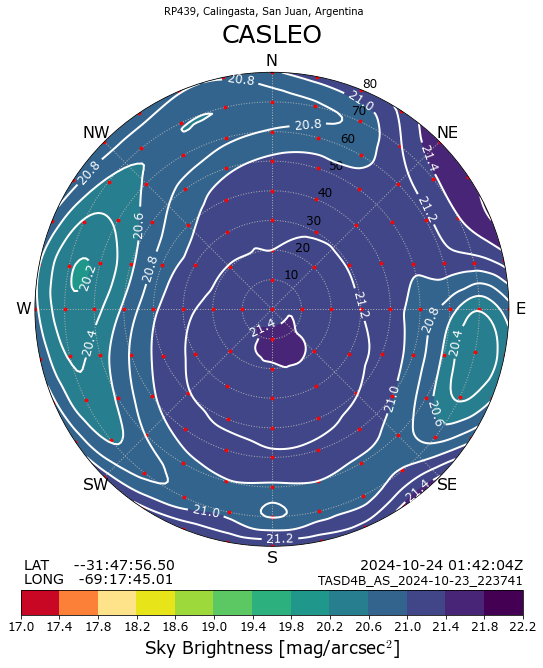

/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/TASD4B_AS_2024-10-23_224926_CASLEO.ecsv
**sitio 
 RP439, Calingasta, San Juan, Argentina
America/Argentina/San_Juan
/Users/jzamorano/Google Drive/My Drive/NixNox/TAS-Contribuciones/TASD4B-ClaudiaAlamo/metadata_name_institution.ecsv
mean_datetime (LT) 2024-10-23 22:53:47
OrderedDict([('keywords', OrderedDict([('measurements_file', 'TASD4B_AS_2024-10-23_224926_CASLEO.txt'), ('location', 'RP439, Calingasta, San Juan, Argentina'), ('place', 'CASLEO'), ('latitude', '-31.79899'), ('longitude', '-69.29582'), ('height', '2531'), ('author', 'Claudia Alamo'), ('association', 'CASLEO'), ('photometer', 'TASD4B'), ('LT_mean_date', '2024-10-23 22:53:47'), ('LT_time_ini', '2024-10-23 22:49:26'), ('LT_time_end', '2024-10-23 23:00:14'), ('timezone', 'America/Argentina/San_Juan'), ('UT_mean_date', '2024-10-24 01:53:47'), ('UT_time_ini', '2024-10-24 01:49:26'), ('UT_time_end', '2024-10-24 02:00:14'), ('comments', '#  TAS

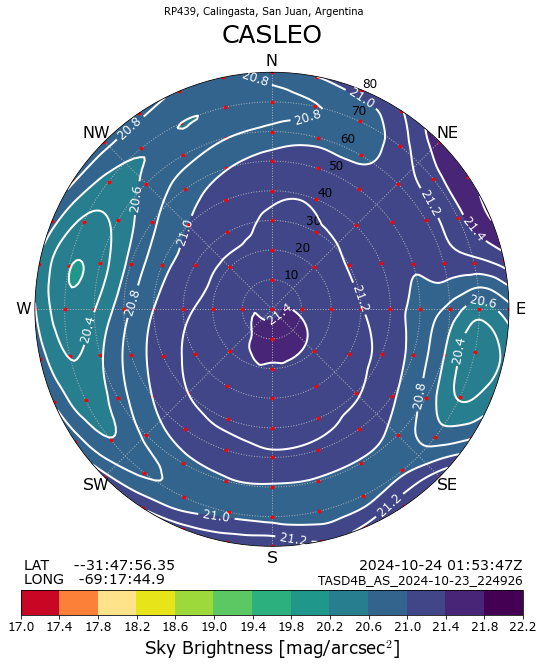

In [18]:
for i in range(len(filelist)):
    file_TAS = filelist[i].replace('txt','ecsv')
    print(file_TAS)
    TASObs(filelist[i],meta_data)
    data = Table.read(file_TAS, format='ascii.ecsv', delimiter=',')
    print(data.meta)
    ##filename = str(file_TAS)
    filename = filelist[i]
    print(filename)
    pos0  = filename.rfind('/')
    pos1  = filename.rfind('_')
    photometer = filename[pos0+1:pos0+7]
    #print('PPPPPP',photometer)
    place = (str(filename[pos1+1:])[:-4]).replace('-',' ')
    '''meta_data = {'author':author,
			  'institution':institution,
			  'photometer': photometer,
			  'place': place,
			  'humidity':'',
			  'comments': comments,
			  'measurements_file': filename}
    '''
    #print(meta_data)
    titulo = data.meta['keywords']['place'] 
    subtitulo = data.meta['keywords']['location']
    print('titulo,subtitulo',titulo,subtitulo)
    #TASObs(filelist[i],meta_data)
    p1 = PhotometerObs(file_TAS,name=titulo,surname=subtitulo)
    # magnitude_map_2(p1, interpolated=True, min_mag=7., max_mag=14.0, cmap='viridis_r')
    magnitude_map_2(p1, interpolated=True, min_mag=17., max_mag=22.0, cmap='viridis_r')
    ### temperature_map2(p1, interpolated=True, min_temp=-40., max_temp=0, cmap='viridis')
#    temperature_map2(p1, interpolated=True, min_temp=20., max_temp=22, cmap='viridis')